In [17]:
from IPython.lib.deepreload import reload as dreload
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from ast import literal_eval
from collections import defaultdict
from itertools import product
from joblib import Parallel, delayed
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from tqdm import tqdm

In [1]:
NOUNS_PATH = "data/french_nouns.csv"
FREQ_PATH = "data/frequencies.csv"
VECTOR_PATH = "data/lemma_pos.txt"
DATA_PATH = "data/nouns_with_features.csv"
MIN_FREQUENCY = 100
RANDOM_STATE = 42

### Loading French Nouns

In [5]:
nouns_df = pd.read_csv(NOUNS_PATH)
nouns_df = nouns_df[nouns_df['gen'] != 'b']

### Loading Frequencies

In [6]:
freq_df = pd.read_csv(FREQ_PATH)
freq_dict = (freq_df[freq_df['word'].str.endswith('NOM')]
           .assign(word_base=lambda x: x['word'].str.split('_').str[0])
           .query('freq >= 100')
           .set_index('word_base')
           .freq
           .to_dict(into=defaultdict(int)))

### Filtering Nouns by Frequency

In [7]:
nouns_df['freq'] = nouns_df['lexeme'].apply(lambda lexeme:freq_dict[lexeme])
nouns_df = nouns_df[nouns_df['freq'] >= MIN_FREQUENCY]
nouns_df = nouns_df.set_index('lexeme', drop=False)
lemmas = nouns_df['lexeme'].to_list()
genders = nouns_df.gen.sample(frac=1)
nouns_df = nouns_df.drop(columns=['lexeme'])
nouns_df

,variants,gen,sg,pl,freq
lexeme,,,,,
à-côté,à-côté:accoté,m,akOte,akOte,1583
à-coup,à-coup,m,aku,aku,829
à-peu-près,à-peu-près,m,apØpʁɛ,apØpʁɛ,1184
à-pic,à-pic,m,apik,apik,241
à-plat,à-plat:aplat,m,apla,apla,314
...,...,...,...,...,...
zozo,zozo,m,zozo,zozo,5929
zozotement,zozotement,m,zOzɔtəmɑ̃,zOzɔtəmɑ̃,121
zydeco,zydeco,f,zidəko,zidəko,181


### Loading Word Embeddings

In [8]:
vectors = {}
with open(VECTOR_PATH, 'r') as file:
    next(file)
    for line in file:
        parts = line.strip().split(maxsplit=1)
        lemma = parts[0]
        vector = [float(x) for x in parts[1].split()]
        if lemma[-4:]=='_nom' and lemma[:-4] in lemmas:
            vectors[lemma[:-4]] = vector

In [9]:
vectors_df = pd.DataFrame(vectors).T.loc[genders.index,:]
vectors_df['embeddings'] = vectors_df.apply(lambda row: row.tolist(), axis=1)
embedding_df = vectors_df[['embeddings']]
embedding_df

,embeddings
lexeme,
goupil,"[0.27221215, -0.09881444, 0.14547586, -0.31488..."
aboi,"[-0.63014644, 0.019612031, 0.78308403, 0.22774..."
coalition,"[-0.36793607, 0.0006372925, 0.19166356, -0.638..."
saumoneau,"[0.2722109, -0.064210154, 0.5550691, -0.485302..."
cuvette,"[0.9073527, -0.17276306, 0.031252317, -0.17126..."
...,...
examinateur,"[0.75524646, -0.21065584, 0.3748033, -0.501016..."
courroux,"[0.012523526, 0.9911931, 0.11212369, -0.048478..."
causerie,"[0.071454614, -0.155308, -0.23812093, -0.34708..."


In [10]:
df = nouns_df.merge(embedding_df, how='inner', left_on='lexeme', right_index=True)
df

,variants,gen,sg,pl,freq,embeddings
lexeme,,,,,,
à-côté,à-côté:accoté,m,akOte,akOte,1583,"[-0.04990138, 0.018498378, -0.017377969, -0.23..."
à-coup,à-coup,m,aku,aku,829,"[0.0829784, -0.17042412, -0.44126853, -0.02323..."
à-peu-près,à-peu-près,m,apØpʁɛ,apØpʁɛ,1184,"[-0.07969671, -0.17768902, -0.061055277, -0.36..."
à-pic,à-pic,m,apik,apik,241,"[0.56577814, -0.05802752, -0.25506887, -0.2604..."
à-plat,à-plat:aplat,m,apla,apla,314,"[0.09909594, 0.2411439, -0.38917032, -0.364075..."
...,...,...,...,...,...,...
zozo,zozo,m,zozo,zozo,5929,"[0.1866128, -0.21195589, 0.35601103, -0.097711..."
zozotement,zozotement,m,zOzɔtəmɑ̃,zOzɔtəmɑ̃,121,"[0.29058978, -0.1037429, -0.03461022, -0.56506..."
zydeco,zydeco,f,zidəko,zidəko,181,"[-0.4816064, -0.36506987, 0.06440003, -0.55367..."


## *Building Phonological Features*

Phonological features were built using right-edge weighted Levenshtein distances. This method calculates phonological similarity by comparing the differences between two strings, emphasizing differences near the right edge of the word.
The phonological distance between nouns was computed relative to their nearest masculine, feminine, and neuter neighbors. Each noun's phonological representation includes these distances as numerical predictors.

In [1]:
def weighted_levenshtein(s1, s2):

    rows = len(s1) + 1
    cols = len(s2) + 1
    matrix = np.zeros((rows, cols))

    # Initialize the first row and column with basic Levenshtein distances
    for i in range(rows):
        matrix[i][0] = i  # Cost of deleting characters from s1
    for j in range(cols):
        matrix[0][j] = j  # Cost of inserting characters into s1

    # Fill the matrix
    for i in range(1, rows):
        for j in range(1, cols):
            # Calculate position from the right edge
            pos_from_right = min(len(s1) - (i - 1), len(s2) - (j - 1))
            weight = 1 / max(1, pos_from_right)  # Higher weight closer to the right

            if s1[i - 1] == s2[j - 1]:
                cost = 0  # No cost for matching characters
            else:
                cost = weight  # Apply weight for substitution

            # Take the minimum of the three possible operations
            matrix[i][j] = min(
                matrix[i - 1][j] + weight,      # Deletion
                matrix[i][j - 1] + weight,      # Insertion
                matrix[i - 1][j - 1] + cost     # Substitution
            )

    return matrix[-1][-1]  # The bottom-right corner contains the final distance

In [2]:
def create_phonological_features(df, n_neighbors=5):
    """
    Create phonological feature vectors where each word has a list of 10 distances:
    - First 5: distances to nearest masculine neighbors
    - Last 5: distances to nearest feminine neighbors
    """

    words_by_gender = {
        'm': [(idx, row['sg']) for idx, row in df[df['gen'] == 'm'].iterrows()],
        'f': [(idx, row['sg']) for idx, row in df[df['gen'] == 'f'].iterrows()]
    }

    feature_vectors = {}

    # Process all words with progress bar
    for (word, row) in tqdm(df.iterrows(), total=len(df)):
        ipa = row['sg']

        # Calculate distances to masculine words in parallel
        m_distances = Parallel(n_jobs=-1)(
            delayed(weighted_levenshtein)(ipa, other_ipa)
            for other_word, other_ipa in words_by_gender['m']
            if other_word != word
        )
        m_distances = sorted(m_distances)[:n_neighbors]

        # Calculate distances to feminine words in parallel
        f_distances = Parallel(n_jobs=-1)(
            delayed(weighted_levenshtein)(ipa, other_ipa)
            for other_word, other_ipa in words_by_gender['f']
            if other_word != word
        )
        f_distances = sorted(f_distances)[:n_neighbors]

        feature_vectors[word] = m_distances + f_distances

    df['phonological_distances'] = pd.Series(feature_vectors)
    return df

## Building Semantic Features

### Neutralize Gender-Specific Textual Information

The corpus is de-gendered to ensure that the model doesn't learn gender from agreement patterns (e.g., the use of masculine or feminine articles).
For example, articles, pronouns, and gendered prepositions must be replaced with neutral placeholders, ensuring the semantic vectors only reflect lexical semantics.

In French dataset, we could not find any nouns that contain determiners.

In [23]:
determiners = ['le', 'la', 'les', 'un', 'une', 'des', 'au', 'aux', 'du', 'de la', 'de l\'', 'mon', 'ton', 'son', 'ma', 'ta', 'sa', 'mes', 'tes', 'ses', 'notre', 'votre', 'nos', 'vos', 'leur', 'leurs', 'ce', 'cet', 'cette', 'ces', 'ceux']
df['contains_determiners'] = df['variants'].apply(lambda x: any(x.startswith(det + ' ') for det in determiners))
rows_with_determiners = df[df['contains_determiners']]
rows_with_determiners

,variants,gen,sg,pl,freq,embeddings,contains_determiners
lexeme,,,,,,,


For each noun, its semantic similarity to the 5 nearest masculine, feminine nouns was computed.

In [3]:
def create_semantic_features(df, n_neighbors=5):

    embeddings = np.stack(df['embeddings'].to_numpy())

    masculine_indices = [df.index.get_loc(idx) for idx in df[df['gen'] == 'm'].index]
    feminine_indices = [df.index.get_loc(idx) for idx in df[df['gen'] == 'f'].index]

    masculine_vectors = embeddings[masculine_indices]
    feminine_vectors = embeddings[feminine_indices]

    feature_vectors = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Computing semantic features"):

        word_vector = row['embeddings']
        word_position = df.index.get_loc(idx)

        # Compute cosine similarity for all at once
        m_similarities = cosine_similarity([word_vector], masculine_vectors).flatten()
        if word_position in masculine_indices:
            # Mask out self-similarity
            m_index = masculine_indices.index(word_position)
            m_similarities[m_index] = -float('inf')  # Set to a very low value to exclude during sorting

        f_similarities = cosine_similarity([word_vector], feminine_vectors).flatten()
        if word_position in feminine_indices:
            f_index = feminine_indices.index(word_position)
            f_similarities[f_index] = -float('inf')  # Set to a very low value to exclude during sorting


        # Get top n_neighbors from each
        m_similarities = sorted(m_similarities, reverse=True)[:n_neighbors]
        f_similarities = sorted(f_similarities, reverse=True)[:n_neighbors]

        feature_vectors.append(m_similarities + f_similarities)

    df['semantic_distances'] = feature_vectors
    return df


In [115]:
df = create_semantic_features(df)

Computing semantic features: 100%|██████████| 24204/24204 [21:18<00:00, 18.94it/s]


In [18]:
df

,variants,gen,sg,pl,freq,embeddings,semantic_distances
lexeme,,,,,,,
à-côté,à-côté:accoté,m,akOte,akOte,1583,"[-0.04990138, 0.018498378, -0.017377969, -0.23...","[0.584885827186455, 0.578469505048747, 0.56802..."
à-coup,à-coup,m,aku,aku,829,"[0.0829784, -0.17042412, -0.44126853, -0.02323...","[0.7033340956548226, 0.6872905876868438, 0.680..."
à-peu-près,à-peu-près,m,apØpʁɛ,apØpʁɛ,1184,"[-0.07969671, -0.17768902, -0.061055277, -0.36...","[0.789419459294777, 0.7877941600724073, 0.7751..."
à-pic,à-pic,m,apik,apik,241,"[0.56577814, -0.05802752, -0.25506887, -0.2604...","[0.8568960087245266, 0.8272328742373337, 0.820..."
à-plat,à-plat:aplat,m,apla,apla,314,"[0.09909594, 0.2411439, -0.38917032, -0.364075...","[0.8014779933313169, 0.7597571318951902, 0.753..."
...,...,...,...,...,...,...,...
zozo,zozo,m,zozo,zozo,5929,"[0.1866128, -0.21195589, 0.35601103, -0.097711...","[0.8390394339900642, 0.8142182429961309, 0.812..."
zozotement,zozotement,m,zOzɔtəmɑ̃,zOzɔtəmɑ̃,121,"[0.29058978, -0.1037429, -0.03461022, -0.56506...","[0.7936751023991188, 0.7589115553647618, 0.707..."
zydeco,zydeco,f,zidəko,zidəko,181,"[-0.4816064, -0.36506987, 0.06440003, -0.55367...","[0.8561342189095774, 0.8288258738052868, 0.826..."


In [19]:
df = create_phonological_features(df)

 61%|██████    | 14746/24204 [1:49:57<1:01:29,  2.56it/s]/Users/zeinab/mambaforge/envs/M2/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 24204/24204 [3:27:23<00:00,  1.95it/s]     


In [ ]:
# Convert the phonological_distances column
df['phonological_distances'] = df['phonological_distances'].apply(
    lambda x: [float(i) if isinstance(i, (np.floating, float)) else i for i in x]
)

In [ ]:
df.to_csv('nouns_with_features.csv')

In [22]:
df

,variants,gen,sg,pl,freq,embeddings,semantic_distances,phonological_distances
lexeme,,,,,,,,
à-côté,à-côté:accoté,m,akOte,akOte,1583,"[-0.04990138, 0.018498378, -0.017377969, -0.23...","[0.584885827186455, 0.578469505048747, 0.56802...","[0.4, 0.5, 0.5833333333333333, 0.5833333333333..."
à-coup,à-coup,m,aku,aku,829,"[0.0829784, -0.17042412, -0.44126853, -0.02323...","[0.7033340956548226, 0.6872905876868438, 0.680...","[0.5, 0.5, 0.5, 0.6666666666666666, 0.66666666..."
à-peu-près,à-peu-près,m,apØpʁɛ,apØpʁɛ,1184,"[-0.07969671, -0.17768902, -0.061055277, -0.36...","[0.789419459294777, 0.7877941600724073, 0.7751...","[0.5, 0.5833333333333333, 0.65, 0.75, 0.783333..."
à-pic,à-pic,m,apik,apik,241,"[0.56577814, -0.05802752, -0.25506887, -0.2604...","[0.8568960087245266, 0.8272328742373337, 0.820...","[0.25, 0.25, 0.3333333333333333, 0.58333333333..."
à-plat,à-plat:aplat,m,apla,apla,314,"[0.09909594, 0.2411439, -0.38917032, -0.364075...","[0.8014779933313169, 0.7597571318951902, 0.753...","[0.5, 0.5, 0.5, 0.5833333333333333, 0.58333333..."
...,...,...,...,...,...,...,...,...
zozo,zozo,m,zozo,zozo,5929,"[0.1866128, -0.21195589, 0.35601103, -0.097711...","[0.8390394339900642, 0.8142182429961309, 0.812...","[0.5833333333333333, 0.5833333333333333, 0.583..."
zozotement,zozotement,m,zOzɔtəmɑ̃,zOzɔtəmɑ̃,121,"[0.29058978, -0.1037429, -0.03461022, -0.56506...","[0.7936751023991188, 0.7589115553647618, 0.707...","[0.37896825396825395, 0.37896825396825395, 0.3..."
zydeco,zydeco,f,zidəko,zidəko,181,"[-0.4816064, -0.36506987, 0.06440003, -0.55367...","[0.8561342189095774, 0.8288258738052868, 0.826...","[0.75, 0.9166666666666665, 0.9166666666666665,..."


## Load Nouns with Features CSV

In [ ]:
df = pd.read_csv(DATA_PATH)
df['embeddings'] = df['embeddings'].apply(literal_eval)
df['semantic_distances'] = df['semantic_distances'].apply(literal_eval)
df['phonological_distances'] = df['phonological_distances'].apply(literal_eval)
df.index = df['lexeme']
df.drop(columns=['lexeme'], inplace=True)
df

### XGBoost Model

In [ ]:
def prepare_features(df, feature_type='both'):
    """
    Prepare features based on specified type
    feature_type: 'phonological', 'semantic', or 'both'
    """
    if feature_type == 'phonological':
        X = np.array(df['phonological_distances'].tolist())
        features = [f'phon_{i+1}' for i in range(10)]
    elif feature_type == 'semantic':
        X = np.array(df['semantic_distances'].tolist())
        features = [f'sem_{i+1}' for i in range(10)]
    else:
        X_phon = np.array(df['phonological_distances'].tolist())
        X_sem = np.array(df['semantic_distances'].tolist())
        X = np.hstack([X_phon, X_sem])
        features = ([f'phon_{i+1}' for i in range(10)] +
                   [f'sem_{i+1}' for i in range(10)])
    y = (df['gen'] == 'f').astype(int)
    return X, y, features

In [ ]:
def train_xgboost_model(X_train, y_train, params=None, use_gpu=False):
    if params is None:
        params = {
            'objective': 'binary:logistic',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'max_depth': 3,
            'random_state': RANDOM_STATE
        }

    if use_gpu:
        params.update({'device': 'cuda'})
    else:
        params.update({'device': 'cpu'})

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

In [ ]:
def evaluate_xgboost_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred,
                                target_names=['masculine', 'feminine'],
                                output_dict=True)

    return accuracy, report

In [ ]:
def cross_validate(X, y, n_folds=10):

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    params = {
        'objective': 'binary:logistic',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'max_depth': 3,
        'random_state': 42
    }

    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = train_xgboost_model(X_train, y_train, params)

        accuracy, report = evaluate_xgboost_model(model, X_test, y_test)

        fold_results.append({
            'fold': fold,
            'accuracy': accuracy,
            'report': report
        })

        print(f"\nFold {fold}:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, model.predict(X_test),
                                 target_names=['masculine', 'feminine']))

    return fold_results

In [ ]:
def compare_features(df, n_splits=10):

    feature_types = ['phonological', 'semantic', 'both']
    results = {}

    for feature_type in feature_types:
        print(f"\nEvaluating {feature_type.upper()} features:")
        print("-" * 50)

        X, y, features = prepare_features(df, feature_type)

        fold_results = cross_validate(X, y, n_splits)

        accuracies = [r['accuracy'] for r in fold_results]
        avg_accuracy = np.mean(accuracies)
        std_accuracy = np.std(accuracies)

        results[feature_type] = {
            'fold_results': fold_results,
            'avg_accuracy': avg_accuracy,
            'std_accuracy': std_accuracy,
            'features': features
        }

        print(f"\nAverage Accuracy: {avg_accuracy:.4f} (±{std_accuracy:.4f})")

    return results

In [ ]:
def calculate_class_metrics(fold_results, class_name: str):
    """
    Calculate average metrics for a specific class across folds
    """
    return {
        'precision': np.mean([r['report'][class_name]['precision'] for r in fold_results]),
        'recall': np.mean([r['report'][class_name]['recall'] for r in fold_results]),
        'f1': np.mean([r['report'][class_name]['f1-score'] for r in fold_results])
    }

In [ ]:
def plot_metrics_heatmap(results):
    metrics_data = []
    for feature_type, result in results.items():
        masculine = calculate_class_metrics(result['fold_results'], 'masculine')
        feminine = calculate_class_metrics(result['fold_results'], 'feminine')

        metrics_data.append({
            'Feature Type': feature_type,
            'Masculine Precision': masculine['precision'],
            'Masculine Recall': masculine['recall'],
            'Masculine F1': masculine['f1'],
            'Feminine Precision': feminine['precision'],
            'Feminine Recall': feminine['recall'],
            'Feminine F1': feminine['f1']
        })

    df = pd.DataFrame(metrics_data).set_index('Feature Type')

    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, fmt='.4f', cmap='YlOrRd', center=0.5)
    plt.title('Detailed Performance Metrics')
    plt.tight_layout()

In [ ]:
results = compare_features(df)


Evaluating PHONOLOGICAL features:
--------------------------------------------------

Fold 1:
Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

   masculine       0.81      0.81      0.81        21
    feminine       0.79      0.79      0.79        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40


Fold 2:
Accuracy: 0.8000

Classification Report:
              precision    recall  f1-score   support

   masculine       0.89      0.74      0.81        23
    feminine       0.71      0.88      0.79        17

    accuracy                           0.80        40
   macro avg       0.80      0.81      0.80        40
weighted avg       0.82      0.80      0.80        40


Fold 3:
Accuracy: 0.7250

Classification Report:
              precision    recall  f1-score   support

   masculine       0.65      0.83      0.73        18
 

In [ ]:
print("\nSummary of Results:")
print("-" * 60)
print(f"{'Feature Type':<15} {'Avg Accuracy':<15} {'Std Dev':<15}")
print("-" * 60)
for feature_type, metrics in results.items():
    print(f"{feature_type:<15} {metrics['avg_accuracy']:.4f}        {metrics['std_accuracy']:.4f}")

print("\nDetailed Class Metrics:")
print("-" * 80)

for feature_type, metrics in results.items():
    print(f"\n{feature_type.upper()} features:")

    # Calculate average precision, recall, f1 for each class
    masculine_metrics = {
        'precision': np.mean([r['report']['masculine']['precision'] for r in metrics['fold_results']]),
        'recall': np.mean([r['report']['masculine']['recall'] for r in metrics['fold_results']]),
        'f1': np.mean([r['report']['masculine']['f1-score'] for r in metrics['fold_results']])
    }

    feminine_metrics = {
        'precision': np.mean([r['report']['feminine']['precision'] for r in metrics['fold_results']]),
        'recall': np.mean([r['report']['feminine']['recall'] for r in metrics['fold_results']]),
        'f1': np.mean([r['report']['feminine']['f1-score'] for r in metrics['fold_results']])
    }

    print("Masculine:")
    print(f"Precision: {masculine_metrics['precision']:.4f}")
    print(f"Recall: {masculine_metrics['recall']:.4f}")
    print(f"F1-score: {masculine_metrics['f1']:.4f}")

    print("\nFeminine:")
    print(f"Precision: {feminine_metrics['precision']:.4f}")
    print(f"Recall: {feminine_metrics['recall']:.4f}")
    print(f"F1-score: {feminine_metrics['f1']:.4f}")


Summary of Results:
------------------------------------------------------------
Feature Type    Avg Accuracy    Std Dev        
------------------------------------------------------------
phonological    0.8100        0.0527
semantic        0.5750        0.0335
both            0.8225        0.0506

Detailed Class Metrics:
--------------------------------------------------------------------------------

PHONOLOGICAL features:
Masculine:
Precision: 0.8170
Recall: 0.8124
F1-score: 0.8093

Feminine:
Precision: 0.8118
Recall: 0.8095
F1-score: 0.8049

SEMANTIC features:
Masculine:
Precision: 0.5726
Recall: 0.6107
F1-score: 0.5828

Feminine:
Precision: 0.5871
Recall: 0.5474
F1-score: 0.5584

BOTH features:
Masculine:
Precision: 0.8223
Recall: 0.8287
F1-score: 0.8218

Feminine:
Precision: 0.8245
Recall: 0.8210
F1-score: 0.8193


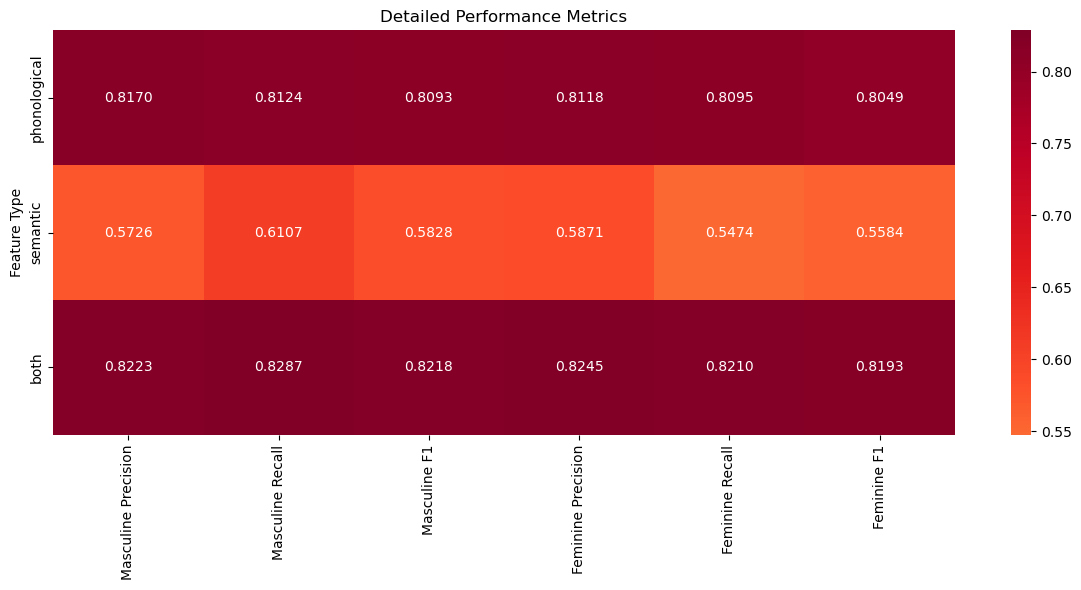

In [ ]:
plot_metrics_heatmap(results)